<a href="https://colab.research.google.com/github/MonitSharma/Quantum-Finance-and-Numerical-Methods/blob/main/Quantum_Amplitude_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Amplitude Estimation

Given a operator $\mathcal{A}$ that acts as:
$$
\mathcal{A}|0\rangle = \sqrt{1 - a}|\Psi_0\rangle + \sqrt{a}|\Psi_1\rangle
$$

We have the task of finding an estimate for the amplitude $a$ of the state $|\Psi_1⟩$

$$ a = |\langle\Psi_1 | \Psi_1\rangle|^2. $$



In [1]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 7.1 MB/s 
     |████████████████████████████████| 12.8 MB 40.6 MB/s 
     |████████████████████████████████| 240 kB 62.0 MB/s 
     |████████████████████████████████| 106 kB 69.8 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 
     |████████████████████████████████| 929 kB 71.1 MB/s 
     |████████████████████████████████| 37.5 MB 336 kB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 50 kB 6.8 MB/s 
     |████████████████████████████████| 4.0 MB 51.3 MB/s 
     |████████████████████████████████| 1.9 MB 69.6 MB/s 
     |████████████████████████████████| 112 kB 75.5 MB/s 
  Created wheel for qiskit: filename=qiskit-0.39.4-py3-none-any.whl size=12274 sha256=6ede48be3cea1e8508f94a86eccf746a758897835421bc17bc6815ff1f64e80f
  Stored in directory: /root/.cache/pip/wheels/40/2c/d7/aa04

We will make use of **Grover Operator**

$$ \mathcal{Q} = \mathcal{A}\mathcal{S}_0\mathcal{A}^\dagger\mathcal{S}_{\Psi_1} $$

where $\mathcal{S}_0$ and $\mathcal{S}_{\Psi_1}$ are just reflections.

$\mathcal{A}$ describes a Bernoulli random variable with (assumed to be unknown) success probability $p$


$$ \mathcal{A}|0\rangle = \sqrt{1 - p}|0\rangle + \sqrt{p}|1\rangle.$$

This is just a rotation around Y-axis of a single qubit 

$$ \mathcal{A} = R_Y(\theta_p), \theta_p = 2\sin^{-1}(\sqrt{p}). $$


and the Grover Operator becomes $$ \mathcal{Q} = R_Y(2\theta_p), $$

whose powers are easy to calculate :       
$$ \mathcal{Q}^k = R_Y(2k\theta_p) $$

In [2]:
# we set p = 0.2
p = 0.2

In [3]:
import numpy as np
from qiskit.circuit import QuantumCircuit


class BernoulliA(QuantumCircuit):

  """ A Circuit that will represent the A operator """

  def __init__(self, probability):
    super().__init__(1) # the circuit on 1 qubit
    theta_p = 2 * np.arcsin(np.sqrt(probability))
    self.ry(theta_p,0)


class BernoulliQ(QuantumCircuit):
  """ A class rep the Q operator """
  def __init__(self, probability):
    super().__init__(1)


    self._theta_p = 2 * np.arcsin(np.sqrt(probability))
    self.ry(2 * self._theta_p, 0)

  def power(self,k):
    # implement the power of Q
    q_k = QuantumCircuit(1)
    q_k.ry(2 * k * self._theta_p,0)
    return q_k

In [4]:
A = BernoulliA(p)
Q = BernoulliQ(p)

In [5]:
from qiskit.algorithms import EstimationProblem
problem = EstimationProblem(state_preparation = A,
                            grover_operator = Q,
                            objective_qubits=[0])

# the "good " state Psi1 is identified as measuring |1> in qubit 0

In [6]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance

backend = BasicAer.get_backend("statevector_simulator")
quantum_instance = QuantumInstance(backend)

## Canonical AE

The canonical QAE follows the form of QPE: it uses $m$ ancilla qubits - initialised in equal superposition to represent the final result, it defines the number of quantum samples as $M= 2^m$ and applies geometrically increasing powers of $\mathcal{Q}$ controlled by the ancillas. 

------------

Eventually it performs a QFT on the ancilla qubits before they are measured , as illustrated
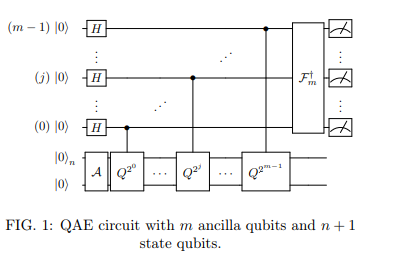

Subsequently the measured integer $y \in \{0,....,M-1\}$ is mapped to an angle $\tilde{\theta}_a = y \pi/M$

Thereafter, the resulting estimate of $a$ is defined as $\tilde{a} = \sin^2(\tilde{\theta_a})$. Then with a probability of at least $8/\pi^2 \approx 81\%$ the estimate $\tilde{a}$ satisfies:

$$ |a-\tilde{a}| \le \frac{2\pi \sqrt{a(1-a)}}{M} + \frac{\pi^2}{M^2}$$

which implies the quadratic speedup over a classical Monte Carlo simulation i.e the estimation error $\epsilon = \mathcal{O}(1/M)$. 

-----------

The success probability can quickly be boosted to $100\%$ by repeating this multiple times and using the mediam estimate. These estimates $\tilde{a}$ are restricted to the grid $\{\sin^2 (y\pi /M) : y = 0,...,M/2\}$

In [19]:
from qiskit.algorithms import AmplitudeEstimation

ae = AmplitudeEstimation(
    num_eval_qubits=5,  # if we increase this value we'll get a better result
    # the number of evaluation qubits specifies circuit width and accuracy
    quantum_instance=quantum_instance,
)

In [20]:
ae_result = ae.estimate(problem)

In [21]:
print(ae_result.estimation)

0.2222149


In [10]:
result = []
for num_eval_qubits in range(3,11):
  ae = AmplitudeEstimation(
    num_eval_qubits=num_eval_qubits,  # if we increase this value we'll get a better result
    # the number of evaluation qubits specifies circuit width and accuracy
    quantum_instance=quantum_instance,)
  ae_result = ae.estimate(problem)
  result.append(ae_result.estimation)


In [11]:
for i in range(len(result)):
  print("For number of Evaluation Qubits",i+3,"the apprximation is",result[i])


For number of Evaluation Qubits 3 the apprximation is 0.1464466
For number of Evaluation Qubits 4 the apprximation is 0.1464466
For number of Evaluation Qubits 5 the apprximation is 0.2222149
For number of Evaluation Qubits 6 the apprximation is 0.1828034
For number of Evaluation Qubits 7 the apprximation is 0.2021503
For number of Evaluation Qubits 8 the apprximation is 0.2021503
For number of Evaluation Qubits 9 the apprximation is 0.2021503
For number of Evaluation Qubits 10 the apprximation is 0.1996918


We can see that the with the increase in number of evaluation qubits we are getting a better approximation to our result of $p=0.2$.

But it is a costly method, since increasing the qubits will increase the computational cost.

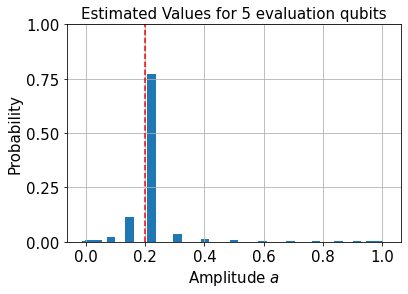

In [22]:

import matplotlib.pyplot as plt
# plot estimated values
gridpoints = list(ae_result.samples.keys())
probabilities = list(ae_result.samples.values())

plt.bar(gridpoints, probabilities, width=0.5 / len(probabilities))
plt.axvline(p, color="r", ls="--")
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title("Estimated Values for 5 evaluation qubits", size=15)
plt.ylabel("Probability", size=15)
plt.xlabel(r"Amplitude $a$", size=15)
plt.ylim((0, 1))
plt.grid()
plt.show()

To improve the estimate we can interpolate the measurement probabilities and compute the maximum likelihood.

For a given $\theta_a$ the probability of observing $|y⟩$ when measuring the ancilla qubits is gievn by ⁉
$$ \mathbb{P}[|y⟩] = \frac{\sin^2 (M \Delta \pi)}{M^2 \sin^2 (\Delta \pi)}$$
where $\Delta$ is the minimal distance on the unit circle between the angles $\theta_a$ and $\pi\tilde{y}/M$ and $\tilde{y} = y$ if $y \le M/2$ and $\tilde{y} = M/2-y$ otherwise.

-------

Given a set of $y$-measurements, this can be leveraged in an MLE to get an estimate of $\theta_a$ that is not restricted to grid points

In [23]:
print("Interpolated mLE Estimator ", ae_result.mle)

Interpolated mLE Estimator  0.20000000514344307


### The Circuit

In [14]:
%pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 162 kB 7.3 MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136833 sha256=49e51b30264b94585db4825fd6988f8a63465531b11533a3e290049109ac2e73
  Stored in directory: /root/.cache/pip/wheels/72/99/be/81d9bcdf5dd5ee5acd8119a9dd5bc07204c9ce205fd341b021
Successfully built pylatexenc


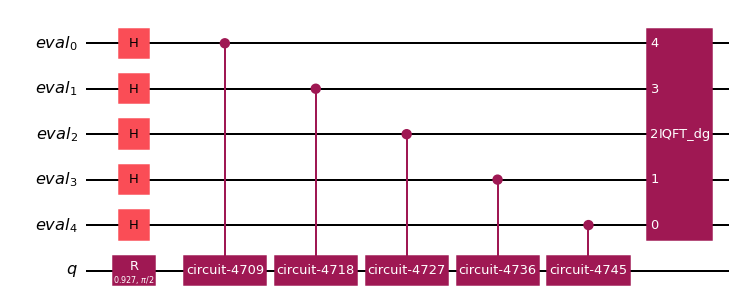

In [24]:
ae_circuit = ae.construct_circuit(problem)
ae_circuit.decompose().draw('mpl', style='iqx')


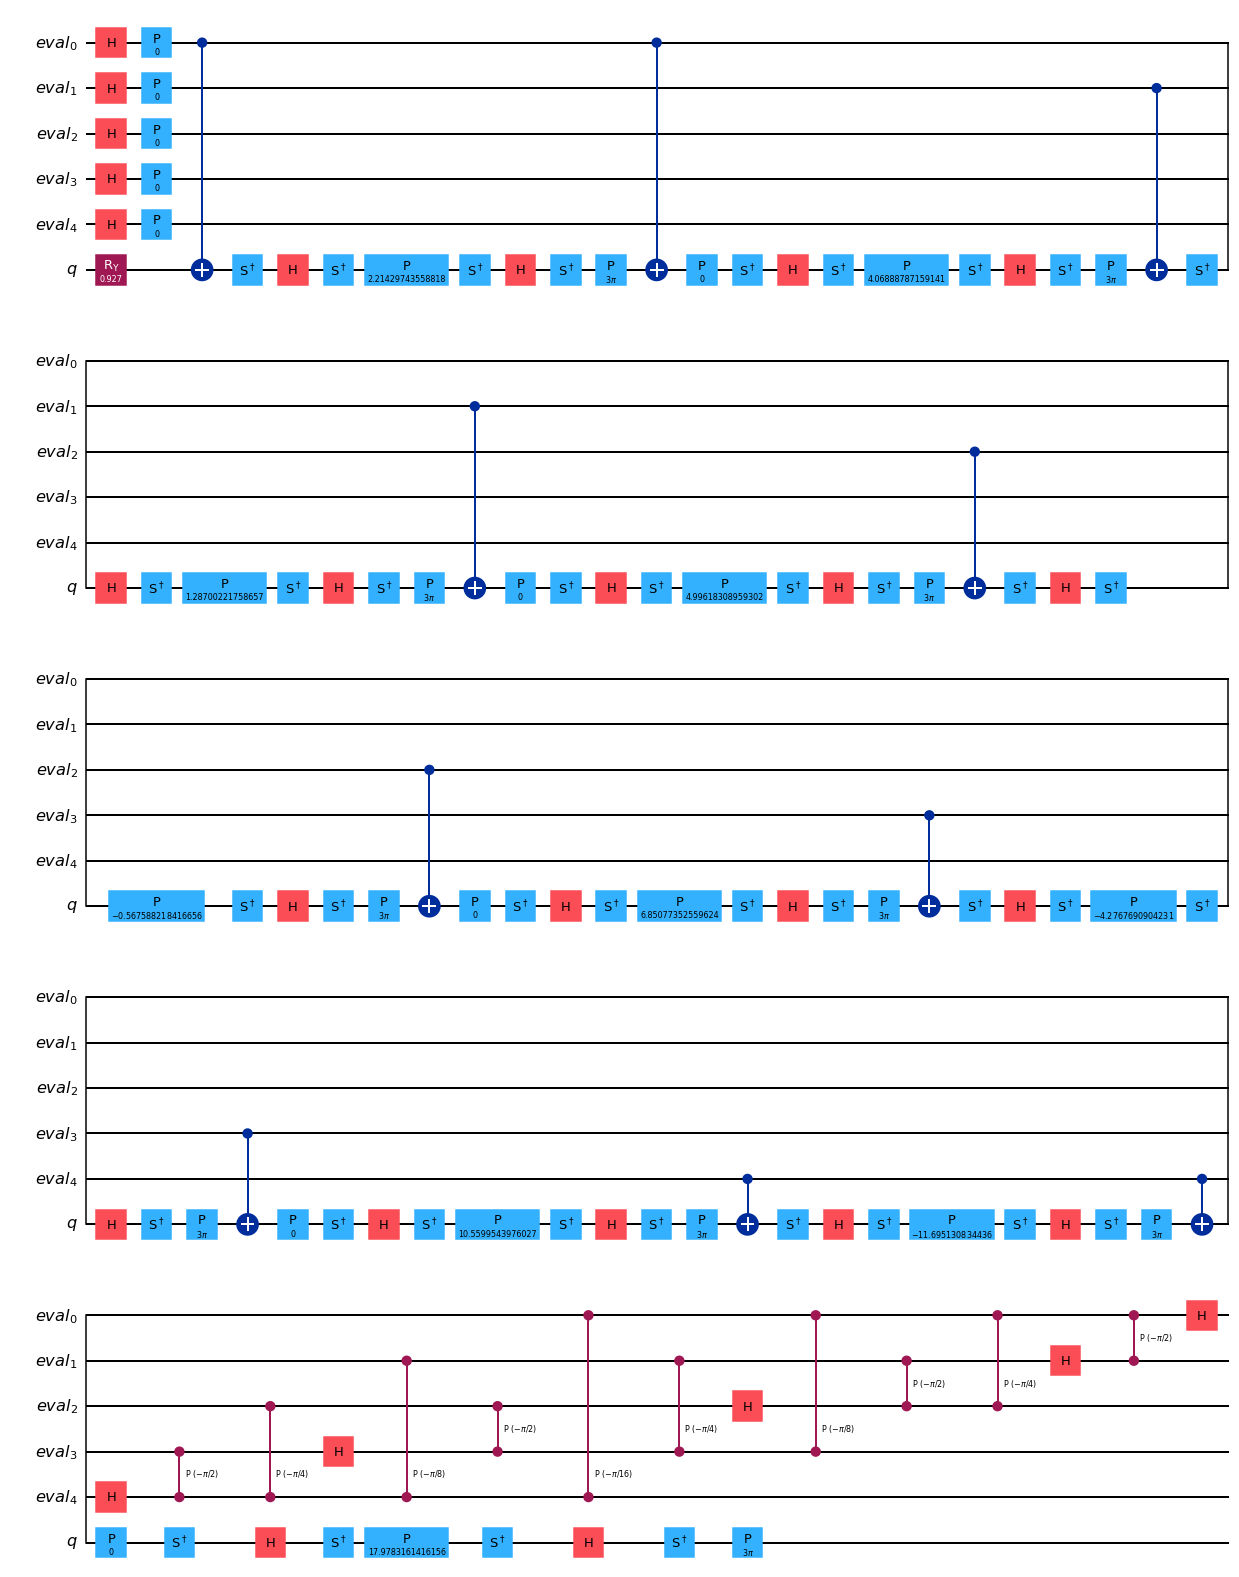

In [25]:
from qiskit import transpile


basis_gates = ["h", "ry", "cry", "cx", "ccx", "p", "cp", "x", "s", "sdg", "y", "t", "cz"]
transpile(ae_circuit, basis_gates=basis_gates, optimization_level=2).draw("mpl", style="iqx")


## Iterative Amplitude Estimation

The output of the algorithm is an estimate that, with at least probability $1-\alpha$, differs by epsilon to the target value, where both $\alpha$ and $\epsilon$ can be specified.

It differes from the original QAE algorithm in that it does not rely on Quantum Phase Estimation, but is only based on Grover's Algorithm. IQAE iteratively applies carefully selected Grover iterations to find an estimate for the target amplitude.


------------------

The output of the algorihtm is an estimate for the amplitude $a$ that with at least probability $1-\alpha$ has an error of $\epsilon$ . The number of $A$ operator calls scales linearly in $1/ϵ$


-------------------


#### Parameters

1.  **epsilon_target** - Target precision for estimation target $a$, has values between $0$ and $0.5$

2.  **alpha** - Confidence level, the target probability is $1-\alpha$, has values between $0$ and $1$

3. **confint_method** - Statistical method used to estimate the confidence intervals in each iteration, can be ‘chernoff’ for the Chernoff intervals or ‘beta’ for the Clopper-Pearson intervals (default)

4. **min_ratio** - Minimal q-ratio for FindNextK


**IQAE iteratively applies carefully selected Grover iterations to find an estimate for the target amplitude.**

------------------------

#### How it does that?

$k$ is the current power of the $\mathcal{Q}$ operator.
The function `find_next_k` find the largest integer `k_next` such that the interval 
$$(4 \times \text{k_next} + 2)\times \text{theta_interval}$$

lies completely in $[0,\pi]$ or $[\pi, 2 \pi]$, for `theta_interval` = (`theta_lower`, `theta_upper`)

This is also governed by the `min_ratio` we provide to be allowed in the algorithm,

$$\frac{K}{K_{next}}$$

The ratio should be larger than $1$ to assure convergence

 ```python
 theta_l, theta_u = theta_interval
 old_scaling = 4 * k + 2 # current scaling factor called K = (4k+2)

 # the largest feasible scaling factor  cannot be larger than K_max,
 # which is bounded by the length of the current confidence interval

 max_scaling = int(1/)2 * (theta_u - theta_l)))

 scaling = max_scaling - (max_scaling - 2) % 4

 # find the largest feasible scaling factor K_next, and thus k_next
        while scaling >= min_ratio * old_scaling:
            theta_min = scaling * theta_l - int(scaling * theta_l)
            theta_max = scaling * theta_u - int(scaling * theta_u)

            if theta_min <= theta_max <= 0.5 and theta_min <= 0.5:
                # the extrapolated theta interval is in the upper half-circle
                upper_half_circle = True
                return int((scaling - 2) / 4), upper_half_circle

            elif theta_max >= 0.5 and theta_max >= theta_min >= 0.5:
                # the extrapolated theta interval is in the upper half-circle
                upper_half_circle = False
                return int((scaling - 2) / 4), upper_half_circle

            scaling -= 4

        # if we do not find a feasible k, return the old one
        return int(k), upper_half_circle




```

All variants of QAE without QPE are based on the fact that:

$$ \mathcal{Q}^k \mathcal{A}|0\rangle_n |0\rangle = \cos((2k+1)\theta_a) |\psi_0\rangle_n |0\rangle + \sin((2k+1)\theta_a) |\psi_1\rangle_n |1\rangle$$


where $\theta_a$ is defined as $a = \sin^2(\theta_a)$$. 

In other words the probability of measuring $|1\rangle$ in the last qubit is ⁉
$$ \mathcal{P}[|1\rangle] = \sin^2 ((2k+1)\theta_a)$$



------------
------------------
The algorithms mainly differ in how they derive the different values for the power $k$ and $\mathcal{Q}$ and how they combine the result into a final estimate of $a$.



**Maximum Likelihood Amplitude Estimation (MLAE)**

MLAE first approximates $\mathbb{P}[|1⟩]$ for $k = 2^j$ and $j = 0,1,2,...,m-1$ for given $m$, using $N_{shots}$ measurements from a quantum computer for each $j$ , i.e in total $\mathcal{Q}$ is applied $N_{shots}(M-1)$ times, where $M= 2^m$

In [30]:
from qiskit.algorithms import IterativeAmplitudeEstimation

iae = IterativeAmplitudeEstimation(
    epsilon_target = 0.01, # target accuracy
    alpha = 0.05, # width of the confidence level
    quantum_instance = quantum_instance

)

iae_result = iae.estimate(problem)

print("Estimate:", iae_result.estimation)

Estimate: 0.19999999999999998


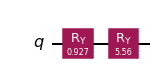

In [31]:
iae_circuit = iae.construct_circuit(problem, k=3) # k is the power of the Q operator.
iae_circuit.draw("mpl", style="iqx")

## Maximum Likelihood Amplitude Estimation

`CLASSMaximumLikelihoodAmplitudeEstimation(evaluation_schedule, minimizer=None, quantum_instance=None, sampler=None)`

1. **evaluation_schedule** - If a list, the powers applied to the Grover operator. The list element must be non-negative. If a non-negative integer, an exponential schedule is used where the highest power is $2$ to the integer minus $1$

2. **minimizer** - A minimizer used to find the minimum of the likelihood funcition. Defaults to a brute search where the number of evaluation points is determined accordinng to the `evaluation_schedule`

In [33]:
from qiskit.algorithms import MaximumLikelihoodAmplitudeEstimation

mlae = MaximumLikelihoodAmplitudeEstimation(
  evaluation_schedule = 3, 
  quantum_instance = quantum_instance
)

mlae_result = mlae.estimate(problem)

print("Estimate: ", mlae_result.estimation)

Estimate:  0.20002237175368104


## Faster Amplitude Estimation


`CLASSFasterAmplitudeEstimation(delta, maxiter, rescale=True, quantum_instance=None, sampler=None)`

The Faster Amplitude Estimation (FAE) algorithm is a variant of Quantum Amplitude Estimation (QAE), where the Quantum Phase Estimation (QPE) by an iterative Grover search, similar to QAE.

Due to the iterative version of the QPE, this algorithm does not require any additional qubits, as the originally proposed QAE and thus the resulting circuits are less complex.


1. **delta** - The probability that the true value is outside of the final confidence interval.

2. **maxiter** - The number of iterations, the maximal power is $\mathcal{Q}$ is $ 2^{maxiter - 1}$

In [35]:
from qiskit.algorithms import FasterAmplitudeEstimation

fae = FasterAmplitudeEstimation(
    delta = 0.01, # target accuracy
    maxiter = 3, # determines the maximal power of the Grover operator
    quantum_instance = quantum_instance,
)

fae_result = fae.estimate(problem)

print("Estimate: ", fae_result.estimation)

Estimate:  0.20000000000000018


/usr/local/lib/python3.8/dist-packages/qiskit/algorithms/amplitude_estimators/estimation_problem.py:195: UserWarning: Rescaling discards the Grover operator.
  warnings.warn("Rescaling discards the Grover operator.")
